# Pareto Chart of Sentence Heads
A dependency parser analyzes the grammatical structure of one or more sentences, establishing relationships between "head" verbs and words which modify those heads.  The "lemmas" of the head verbs are their infinitive forms (e.g., the lemma of verbs "said" and "says" is "say."  This script reads a JSON file of the verbs and their lemmas and uses the lemmas to construct a Pareto chart.  Lemmas are used so that the same verb in different forms gets aggregated.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import json

# Make matplotlib plot in notebook rather than externally
%matplotlib inline

## Pareto Chart Drawing Function
From https://github.com/tisimst/paretochart/blob/master/paretochart/paretochart.py

In [2]:
def pareto(data, labels=[], cumplot=True, axes=None, limit=1.0,
           data_args=(), data_kw={}, line_args=(), line_kw={},
           limit_kw={}):
    """
    Plots a `pareto chart`_ of input categorical data. NOTE: The matplotlib
    command ``show()`` will need to be called separately. The default chart
    uses the following styles:
    
    - bars: 
       - color = blue
       - align = center
       - width = 0.9
    - cumulative line:
       - color = blue
       - linestyle = solid
       - markers = None
    - limit line:
       - color = red
       - linestyle = dashed
    
    Parameters
    ----------
    data : array-like
        The categorical data to be plotted (not necessary to put in descending
        order prior).
        
    Optional
    --------
    labels : list
        A list of strings of the same length as ``data`` that provide labels
        to the categorical data. If none provided, a simple integer value is
        used to label the data, relating to the original order as given. If
        a list is provided, but not the same length as ``data``, then it will
        be treated as if no labels had been input at all.
    cumplot : bool
        If ``True``, a cumulative percentage line plot is included in the chart
        (Default: True) and a second axis indicating the percentage is returned.
    axes : axis object(s)
        If valid matplotlib axis object(s) are given, the chart and cumulative
        line plot of placed on the given axis. Otherwise, a new figure is
        created.
    limit : scalar
        The cumulative percentage value at which the input data should be 
        "chopped off" (should be a value between zero and one).
    data_args : tuple
        Any valid ``matplotlib.pyplot.bar`` non-keyword arguments to apply to
        the bar chart.
    data_kw : dict
        Any valid ``matplotlib.pyplot.bar`` keyword arguments to apply to
        the bar chart.
    line_args : tuple
        Any valid ``matplotlib.pyplot.plot`` non-keyword arguments to apply to
        the cumulative line chart.
    line_kw : dict
        Any valid ``matplotlib.pyplot.plot`` keyword arguments to apply to
        the cumulative line chart.
    limit_kw : dict
        Any valid ``matplotlib.axes.axhline`` keyword arguments to apply to
        the limit line.
        
    Returns
    -------
    fig : matplotlib.figure
        The parent figure object of the chart.
    ax1 : matplotlib.axis
        The axis for the categorical data.
    ax2 : matplotlib.axis
        The axis for the cumulative line plot (not returned if 
        ``cumplot=False``).
    
    Examples
    --------
    
    The following code is the same test code if the ``paretoplot.py`` file is
    run with the command-line call ``$ python paretoplot.py``::
        # plot data using the indices as labels
        data = [21, 2, 10, 4, 16]
        
        # define labels
        labels = ['tom', 'betty', 'alyson', 'john', 'bob']
        
        # create a grid of subplots
        fig,axes = plt.subplots(2, 2)
        
        # plot first with just data
        pareto(data, axes=axes[0, 0])
        plt.title('Basic chart without labels', fontsize=10)
        
        # plot data and associate with labels
        pareto(data, labels, axes=axes[0, 1], limit=0.75, line_args=('g',))
        plt.title('Data with labels, green cum. line, limit=0.75', fontsize=10)
        
        # plot data and labels, but remove lineplot
        pareto(data, labels, cumplot=False, axes=axes[1, 0], 
               data_kw={'width': 0.5, 'color': 'g'})
        plt.title('Data without cum. line, bar width=0.5', fontsize=10)
        
        # plot data cut off at 95%
        pareto(data, labels, limit=0.95, axes=axes[1, 1], limit_kw={'color': 'y'})
        plt.title('Data trimmed at 95%, yellow limit line', fontsize=10)
    
        # format the figure and show
        fig.canvas.set_window_title('Pareto Plot Test Figure')
        plt.show()
    .. _pareto chart: http://en.wikipedia.org/wiki/Pareto_chart
    
    """
    # re-order the data in descending order
    data = list(data)
    n = len(data)
    if n!=len(labels):
        labels = range(n)
    ordered = sorted(zip(data, labels), key=itemgetter(0), reverse=True)
    ordered_data = [dat for dat, lab in ordered]
    ordered_labels = [lab for dat, lab in ordered]
    
    
    
    # allow trimming of data (e.g. 'limit=0.95' keeps top 95%)
    assert 0.0 <= limit <= 1.0, 'limit must be a positive scalar between 0.0 and 1.0'
    
    # create the cumulative line data
    line_data = [0.0]*n
    total_data = float(sum(ordered_data))
    for i, dat in enumerate(ordered_data):
        if i==0:
            line_data[i] = dat/total_data
        else:
            line_data[i] = sum(ordered_data[:i+1])/total_data

    # determine where the data will be trimmed based on the limit
    ltcount = 0
    for ld in line_data:
        if ld<limit:
            ltcount += 1
    limit_loc = range(ltcount+1)
    
    limited_data = [ordered_data[i] for i in limit_loc]
    limited_labels = [ordered_labels[i] for i in limit_loc]
    limited_line = [line_data[i] for i in limit_loc]
    
    # if axes is specified, grab it and focus on its parent figure; otherwise,
    # create a new figure
    if axes:
        plt.sca(axes)
        ax1 = axes
        fig = plt.gcf()
    else:
        fig = plt.gcf()
        ax1 = plt.gca()
    
    # create the second axis
    if cumplot:
        ax2 = ax1.twinx()
    
    # plotting
    # if not data_kw.has_key('align'):
    if 'align' not in data_kw:
        data_kw['align'] = 'center'
    # if not data_kw.has_key('width'):
    if 'width' not in data_kw:
        data_kw['width'] = 0.9
    ax1.bar(limit_loc, limited_data, *data_args, **data_kw)
    if cumplot:
        ax2.plot(limit_loc, [ld*100 for ld in limited_line], *line_args, 
                 **line_kw)
    
    ax1.set_xticks(limit_loc)
    ax1.set_xlim(-0.5,len(limit_loc)-0.5)
    
    # formatting
    if cumplot:
        # since the sum-total value is not likely to be one of the tick marks,
        # let's make it the top-most one, regardless of label closeness
        ax1.set_ylim(0, total_data)
        loc = ax1.get_yticks()
        newloc = [loc[i] for i in range(len(loc)) if loc[i]<=total_data]
        newloc += [total_data]
        ax1.set_yticks(newloc)
        ax2.set_ylim(0, 100)
        if limit<1.0:
            xmin,xmax = ax1.get_xlim()
            # if not limit_kw.has_key('linestyle'):
            if 'linestyle' not in limit_kw:
                limit_kw['linestyle'] = '--'
            # if not limit_kw.has_key('color'):
            if 'color' not in limit_kw:
                limit_kw['color'] = 'r'
            ax2.axhline(limit*100, xmin-1, xmax-1, **limit_kw)
    
    # set the x-axis labels
    # ax1.set_xticklabels(limited_labels)
    ax1.set_xticklabels(limited_labels, rotation=45) # jld addition
    
    # adjust the second axis if cumplot=True
    if cumplot:
        yt = [str(int(it))+r'%' for it in ax2.get_yticks()]
        ax2.set_yticklabels(yt)

    if cumplot:
        return fig,ax1,ax2
    else:
        return fig,ax1

def test():
    # plot data using the indices as labels
    data = [21, 2, 10, 4, 16]
    
    # define labels
    labels = ['tom', 'betty', 'alyson', 'john', 'bob']
    
    # create a grid of subplots
    fig,axes = plt.subplots(2, 2)
    
    # plot first with just data
    pareto(data, axes=axes[0, 0])
    plt.title('Basic chart without labels', fontsize=10)
    
    # plot data and associate with labels
    pareto(data, labels, axes=axes[0, 1], limit=0.75, line_args=('g',))
    plt.title('Data with labels, green cum. line, limit=0.75', fontsize=10)
    
    # plot data and labels, but remove lineplot
    pareto(data, labels, cumplot=False, axes=axes[1, 0], 
           data_kw={'width': 0.5, 'color': 'g'})
    plt.title('Data without cum. line, bar width=0.5', fontsize=10)
    
    # plot data cut off at 95%
    pareto(data, labels, limit=0.95, axes=axes[1, 1], limit_kw={'color': 'y'})
    plt.title('Data trimmed at 95%, yellow limit line', fontsize=10)

    # format the figure and show
    fig.canvas.set_window_title('Pareto Plot Test Figure')
    plt.show()

In [3]:
# read root verb data from json file
df = pd.read_json('caliNewsPaper_verbList.json', orient='records')

# create new column of mixed-case lemmas converted to lower case; call it "root"
df['root'] = df['lemma'].str.lower()
df

,lemma,verb,root
0,urge,urged,urge
1,write,wrote,write
2,urge,urge,urge
3,co-sign,co-signed,co-sign
4,read,read,read
5,leave,left,leave
6,carry,carries,carry
7,head,heading,head
8,be,were,be
9,go,go,go


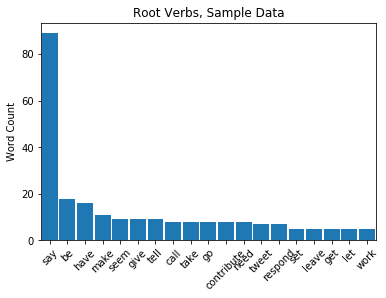

In [4]:
# Create Pareto chart using value counts of series "root."  In the Pareto
# chart, the count of each verb is represented by the height of its bar.  
# The verb counts are in a list called "data" (no pre-sorting necessary).
data = df['root'].value_counts().tolist()

# The verbs are in a list called "labels" in 
# the same order as their counts in "data."
labels = df['root'].value_counts().keys().tolist()

# create a grid of subplots
# fig,axes = plt.subplots(2, 2)

# plot first with just data
# pareto(data, axes=axes[0, 0])
# plt.title('Basic chart without labels', fontsize=10)

# plot data and associate with labels
fig, ax1 = pareto(data, labels, cumplot=False, limit=0.38) # limit=0.35
ax1.set_ylabel('Word Count')

# make manual adjustments to the y-axes
# ax1.set_ylim(top=201)
# ax1.set_yticks(range(0,201,20))
# ax2.set_ylim(top=int((100*(201/sum(data)))))
# ax2.set_yticks(range(0,int(100*(201/sum(data))),20))
# doesn't work:  ax1.set_xticklabels(rotation=45)

plt.title('Root Verbs, Sample Data', fontsize=12)

plt.savefig('verb_pareto.png', bbox_inches='tight')
plt.show()
plt.close(fig)